[View in Colaboratory](https://colab.research.google.com/github/findingfoot/ML_practice-codes/blob/master/Nearest_Neighbors_TF.ipynb)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
from sklearn import datasets
import requests

In [0]:
sess = tf.Session()

In [0]:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'

headers = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 
           'PTRATIO', 'B', 'LSTAT', 'MEDV']
columns = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

features = len(columns)

housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

In [0]:
y_vals = np.transpose([np.array([y[13] for y in housing_data ])])

x_vals = np.array([[x for i,x in enumerate(y) if headers[i] in columns] for y in housing_data])

In [0]:
#do the min max scaling - normailizing the data
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

In [0]:
x_vals

array([[0.00000000e+00, 6.78152493e-02, 3.14814815e-01, ...,
        2.87234043e-01, 1.00000000e+00, 8.96799117e-02],
       [2.35922539e-04, 2.42302053e-01, 1.72839506e-01, ...,
        5.53191489e-01, 1.00000000e+00, 2.04470199e-01],
       [2.35697744e-04, 2.42302053e-01, 1.72839506e-01, ...,
        5.53191489e-01, 9.89737254e-01, 6.34657837e-02],
       ...,
       [6.11892474e-04, 4.20454545e-01, 3.86831276e-01, ...,
        8.93617021e-01, 1.00000000e+00, 1.07891832e-01],
       [1.16072990e-03, 4.20454545e-01, 3.86831276e-01, ...,
        8.93617021e-01, 9.91300620e-01, 1.31070640e-01],
       [4.61841693e-04, 4.20454545e-01, 3.86831276e-01, ...,
        8.93617021e-01, 1.00000000e+00, 1.69701987e-01]])

In [0]:
seed = 23
np.random.seed(seed)
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

In [0]:
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]

y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]


In [0]:
x_vals_train.shape

(405, 10)

In [0]:
y_vals_train.shape

(405, 1)

In [0]:
k = 5
batch_size = len(x_vals_test)

In [0]:
#create the placeholders

x_data_train = tf.placeholder(shape = [None, features], dtype= tf.float32)
x_data_test = tf.placeholder(shape=[None, features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [0]:
print(x_data_train.shape)
print(x_data_test.shape)

(?, 10)
(?, 10)


In [0]:
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), axis=2)

In [0]:
#prediction = tf.arg_min(distance, 0)
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals), axis=[1])
#prediction = tf.reduce_mean(top_k_yvals, 1)

# Calculate MSE
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

# Calculate how many loops over training data
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})

    print('Batch #' + str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))


Batch #1 MSE: 20.343


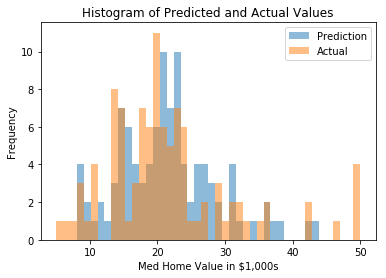

In [0]:
%matplotlib inline
# Plot prediction and actual distribution
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()